# Molecular Dynamics Simulation



Particles interact via a Lennard-Jones potential

$$ V(r) = 4 \epsilon \left( \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^{6} \right) $$


The system will be held at constant temperature $T$. In order to accomplish that, special boundary conditions will be assumed at the walls of the box (a thermostat at constant temperature). When a particle collides with any of the walls, the tangential component of the velocity of the particle is conserved, and the incident normal velocity $v_{n}$  is updated into an outgoing normal velocity $v_{n}^{\prime}$ given by (van Beijeren, 2014):
$$v_{n}^{\prime} = \sqrt{ -\frac{2}{\beta m} \ln \left( 1 - exp\left( -\frac{\beta m v_{n}^{2}}{2} \right) \right)}$$
where $\beta = 1 / k_{B}T $ and $m$ is the mass of the particles, all assumed identical

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
from numba import jit, njit
from numpy.linalg import norm
from collections import Counter
from scipy.spatial.distance import pdist, squareform

from IPython import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output

plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['animation.embed_limit'] = 2**128
plt.style.use('seaborn-whitegrid')

## Governing Forces

Potential function is

$$
u(r) = 4 \epsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^{6} \right] .
$$

or in dimensionless distance $r^{\prime} = r/\sigma$

$$
u(r) = 4 \epsilon \left[ \left( \frac{1}{r^{\prime}} \right)^{12} - \left( \frac{1}{r^{\prime}} \right)^{6} \right] .
$$


Force is computed by taking the derivative of the Lennard-Jones potential with respect to the interparticle separation distance $r_{ij} = \| \mathbf{r}_{ij} \|$

$$ \mathbf{f}_{ij} = - \frac{d u(r_{ij})}{d r_{ij}} \hat{r}_{ij} $$

Taking the derivative of $u(r_{ij})$, and substituting $V^{\prime} = V/\epsilon$

$$ \mathbf{f}_{ij} = 4 \left( - \frac{12}{r^{13}} + \frac{6}{r^{7}} \right) $$





### Dimensionless Length



Since we are working in units of $r^{\prime} = r/\sigma$ and $L^{\prime} = L / \sigma$, and our box has side length $L^{\prime} = 10$, the sides of the box are $10 \sigma$.



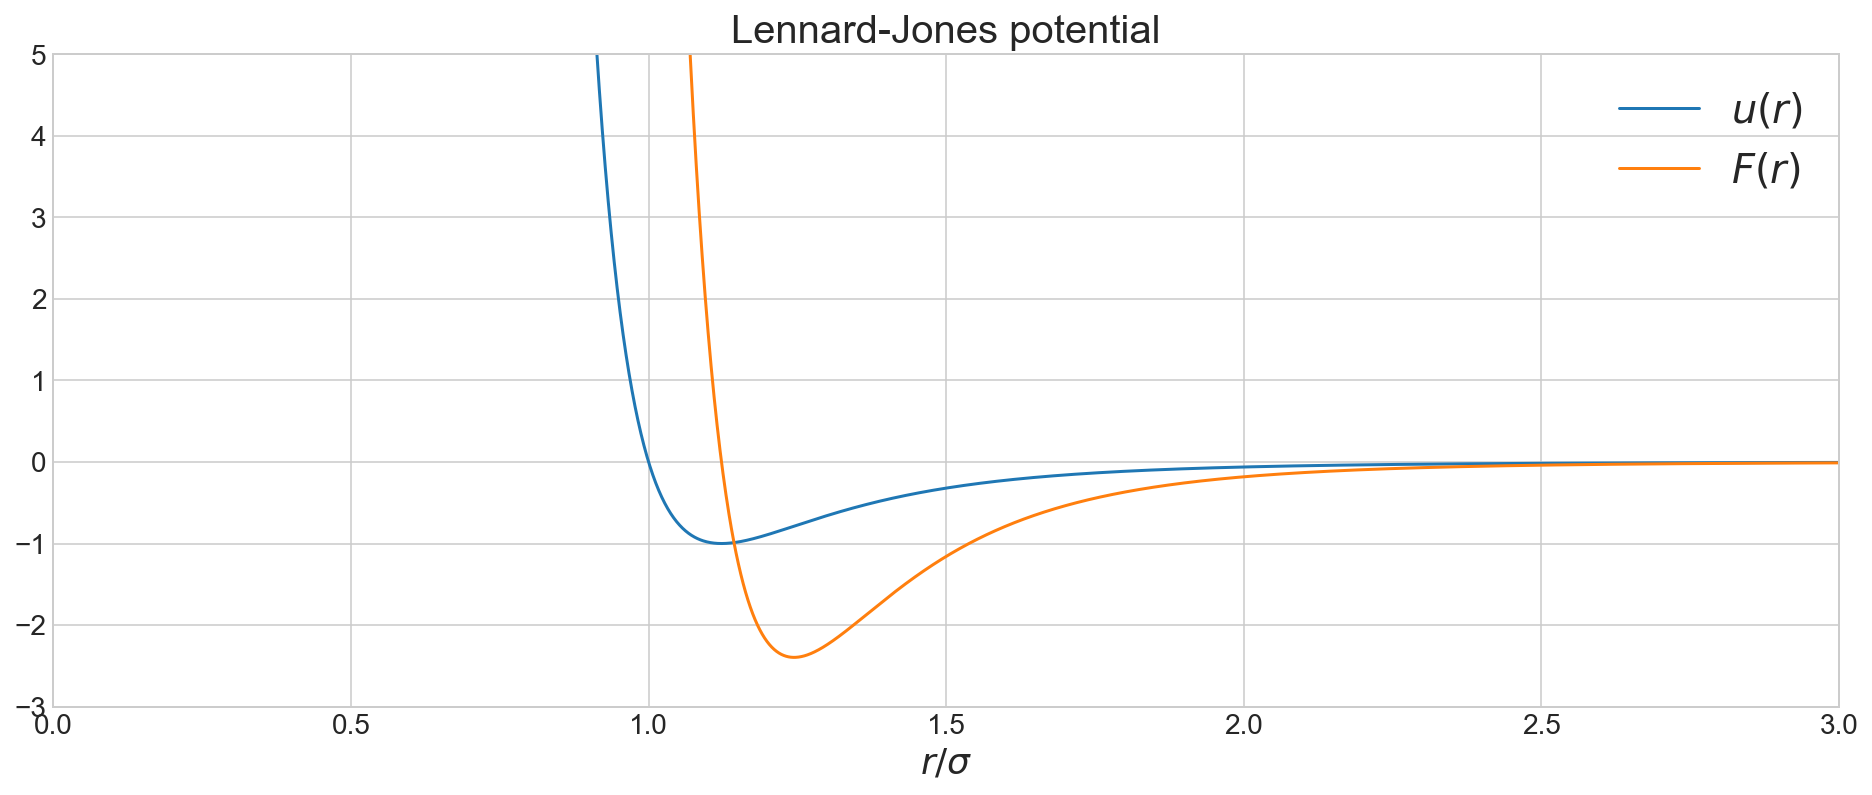

In [2]:
σ = 1
L = 10*σ
r = np.linspace(0.01,L,10000) 
u = 4*((σ/r)**12 - (σ/r)**6)
dudr = (4.0*(-12/r**13 + 6.0/r**7)) 
f = - dudr 

plt.figure(figsize=(16,6))
plt.plot(r,u, label="$u(r)$")
plt.plot(r,f, label="$F(r)$")
plt.title("Lennard-Jones potential", fontsize=20)
plt.xlabel("$r / \sigma$", fontsize=18)
plt.xlim([0, 3])
plt.ylim([-3,5])
plt.legend(prop={"size":20})
plt.show()

## Boundary Conditions

The incident normal velocity $v_{n}$  is updated into an outgoing normal velocity $v_{n}^{\prime}$ given by
$$v_{n}^{\prime} = \sqrt{ -\frac{2}{\beta m} \ln \left( 1 - \mathrm{exp}\left( -\frac{\beta m v_{n}^{2}}{2} \right) \right)}$$
where $\beta = 1 / k_{B}T $ and $m$ is the mass of the particles, all assumed identical


Take quantities $ \tau , \epsilon^{\prime} $, where

$$\tau = \sqrt{\frac{m \sigma^{2}}{\epsilon}} $$

$$ \epsilon^{\prime} = \frac{\epsilon}{k_{B}T}  $$


Using dimensionless velocity $ v^{\prime} = v (\tau / \sigma) $, the equation for outgoing normal velocity $v_{n}^{\prime}$ is

$$ v_{n}^{\prime} = \sqrt{ - \frac{2}{\epsilon^{\prime}}\ln \left(1 - \mathrm{exp}\left(-\frac{1}{2} \epsilon^{\prime } v_n \right) \right) } $$

which has dimensions of $ \sigma / \tau $

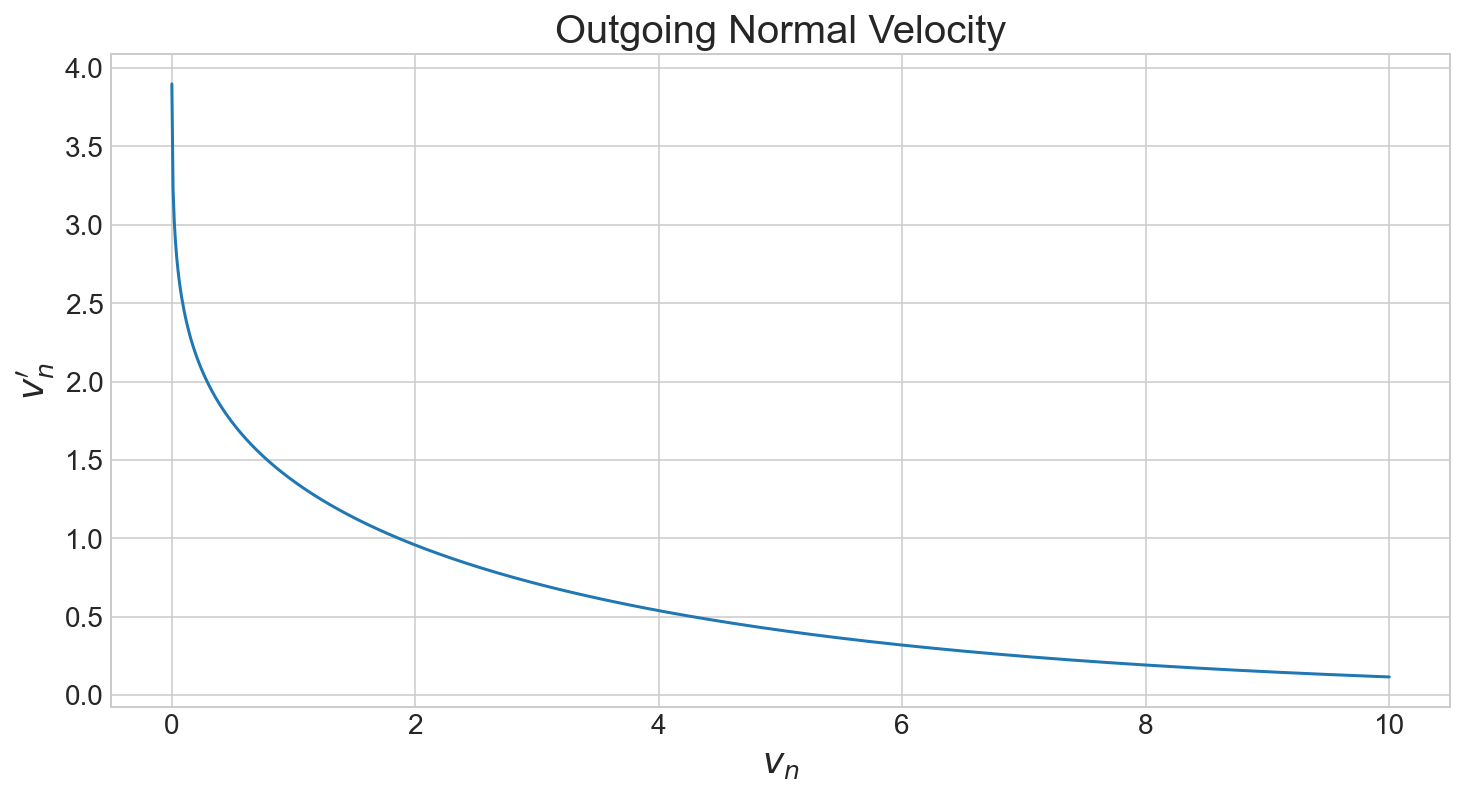

In [3]:
ε_ = 1
v = np.linspace(0.001,10,1000)
v_reflected = np.sqrt(- (2/ε_) * np.log(1 - np.exp(-(1/2)*ε_*np.abs(v))))

plt.figure(figsize=(12,6))
plt.plot(v,v_reflected)
plt.title("Outgoing Normal Velocity", fontsize=20)
plt.xlabel("$v_{n}$", fontsize=18)
plt.ylabel("$ v_{n}^{\prime} $", fontsize=18)
plt.show()

## Initial Conditions

Initial conditions for velocity follows Maxwell-Boltzmann distribution, where average kinetic energy satisfies

$$
<KE> = \frac{1}{2} \sum_{i=1}^{N} m \langle v_{i}^{2} \rangle = N k_{B}T, \quad (v^{2} = v_{x}^{2} + v_{y}^{2})
$$

since we have $k_{B} = 1$, the temperature is

$$ T = \frac{\langle KE \rangle}{N} $$


We want to initialize the velocities so that they satisfy

$$
\langle v_{x} \rangle = \langle v_{y} \rangle = 0
$$

This is done by placing the particles on an evenly spaced grid all with zero initial velocity. The particle positions are then perturbed slightly. 

n = 10 , scale_factor = 0.9090909090909091


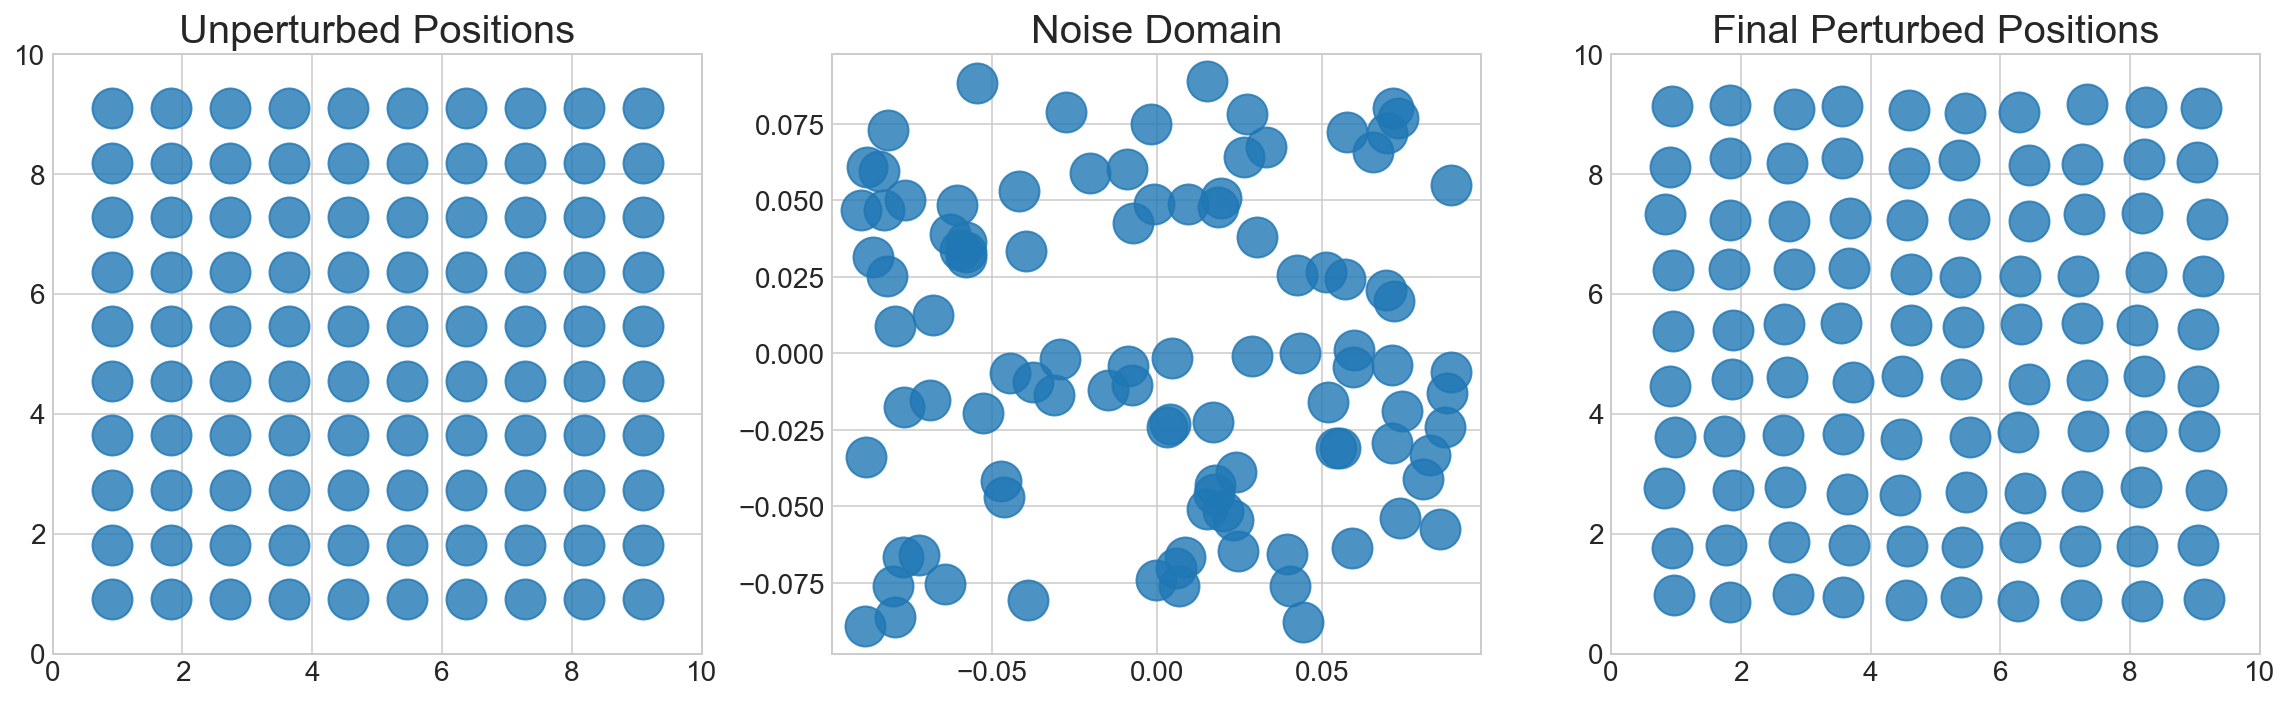

In [4]:
N = 100
L = 10
η = 0.1

n = int(np.sqrt(N))
scale_factor  = L/(n+1)
print("n = {} , scale_factor = {}".format(n, scale_factor))

grid_points = np.array([np.array([(1 + i%n), (1 + int(i/n))]) for i in range(N)])
r0 = grid_points * scale_factor 
noise = np.random.uniform(-1,1,(N,2))*η*scale_factor
grid = r0 + noise

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.scatter(r0[:,0], r0[:,1], s=400, alpha=0.8)
plt.xlim([0, L])
plt.ylim([0, L])
plt.title("Unperturbed Positions", fontsize=20)

plt.subplot(1,3,2)
plt.scatter(noise[:,0], noise[:,1], s=400, alpha=0.8)
plt.title("Noise Domain", fontsize=20)

plt.subplot(1,3,3)
plt.scatter(grid[:,0], grid[:,1], s=400, alpha=0.8)
plt.xlim([0, L])
plt.ylim([0, L])
plt.title("Final Perturbed Positions", fontsize=20)

plt.tight_layout()
plt.show()

In [5]:
class Simulation:

    def __init__(self, N=100, ε=1, L=10, η=0.1, r0=2.5, log_metrics=False, verbose=0):
        self.N = N
        self.ε = ε
        self.L = L
        self.η = η
        self.r0 = r0
        self.t = 0
        self.iter = 0
        self.log_metrics = log_metrics
        self.verbose = verbose
        
        self.t_steps = []
        self.rAvg = []
        self.E_tot = []
        self.K = []
        self.U = []
        self.v2Avg = []
        self.n_collisions = 0
        self.collision_distances = []
        
        self.r = self.r_initial() 
        self.v = np.zeros_like(self.r)
        self.F = np.zeros_like(self.r)

        
    def r_initial(self):
        n = int(np.sqrt(self.N)) # Number of particles along one edge
        σ0 = self.L/(n+1) # Lattice spacing
        r0 = np.array([np.array([(1+i%n), (1+int(i/n))]) for i in range(self.N)])*σ0 # Place particles on lattice
        rp = np.random.uniform(-1,1,(self.N,2))*self.η*σ0 # Randomly perturb the particle positions 
        return r0 + rp 
    
    
    def compute_vnp(self, vn):
        return np.sqrt(-(2/self.ε)*np.log(1-np.exp(-(1/2)*self.ε*np.abs(vn))))
    

    def compute_norms(self, r):
        return squareform(pdist(r))

    
    def compute_U(self, r):
        return 4*((1/r)**12 - (1/r)**6)
    
    
    def compute_F_net(self):
        # Get the indicies ij of particles separated by less than r0    
        iarr, jarr = np.where(self.compute_norms(self.r) < self.r0)

        # To avoid double-counting, only keep the pairs with i < j
        k = iarr < jarr
        iarr, jarr = iarr[k], jarr[k]
        self.n_collisions = len(iarr)

        # Sum the force from each interaction
        F = np.zeros_like(self.r) # Force on each particle
        for i, j in zip(iarr,jarr): # Only iterate through i,j parts that are interacting significantly
            rij = self.r[j] - self.r[i]
            
            rij_norm = norm(rij)
            rij_hat = rij / rij_norm
            self.collision_distances.append(rij_norm)
            # Computation is much faster if you do powers of 6 and 12 instead of 7 and 13
            fij = (24.0/rij_norm)*((2.0/rij_norm**12)-(1.0/rij_norm**6)) * rij_hat 
            # rij points from 1 to 2, so ...
            F[i] += - fij # - rij_hat direction
            F[j] +=   fij # + rij_hat direction

        return F  
    
    
    def apply_boundary_conditions(self):
        # Apply boundary conditions to each particle
        hit_left_wall = self.r[:, 0] <= 0
        hit_right_wall = self.r[:, 0] >= self.L 
        hit_bottom_wall = self.r[:, 1] <= 0
        hit_top_wall = self.r[:, 1] >=  self.L
        
        self.v[hit_left_wall, 0] = self.compute_vnp(self.v[hit_left_wall, 0])
        self.v[hit_right_wall, 0] = - self.compute_vnp(self.v[hit_right_wall, 0])
        self.v[hit_bottom_wall, 1] = self.compute_vnp(self.v[hit_bottom_wall, 1])
        self.v[hit_top_wall, 1] = - self.compute_vnp(self.v[hit_top_wall, 1])
        
        
    def advance(self, Δt):
        self.collision_distances = []
        self.t_steps.append(self.t)
        self.t += Δt
        self.iter += 1
        
        ##### Apply boundary conditions #####
        self.apply_boundary_conditions()
        
        ##### Advance particle positions #####
        self.r = self.r + Δt*self.v + 0.5*Δt**2*self.F 
        
        ##### Calculate new force vectors #####
        F_new = self.compute_F_net() 
        
        ##### Advance velocities #####
        self.v = self.v + 0.5*Δt*(self.F+F_new)
        self.F = F_new
        
        ##### Compute and log metrics #####
        if sim.log_metrics:
            norms = np.ndarray.flatten(self.compute_norms(self.r))
            K = np.sum(0.5 * np.array([np.dot(vi,vi) for vi in self.v]))
            U = - np.sum(self.compute_U(np.array([d for d in norms if d!=0])))
            E_tot = K + U
            T = K/self.N
            rAvg = np.mean(self.compute_norms(self.r))
            self.K.append(K)
            self.U.append(U)
            self.E_tot.append(E_tot)
            v2Avg = 2*K / self.N
            self.rAvg.append(rAvg)
            self.v2Avg.append(v2Avg)
            
        if (self.verbose == 1) and (self.iter % 10 == 0):
            print("t = {:.6f}".format(self.t))
            print("N_collisions = {}".format(self.n_collisions))
            F = lambda d: (4.0/d)*(12/d**12 - 6.0/d**6)
            d_min = min(self.collision_distances)
            F_max = F(d_min)
            print("d_min = {:.3f}".format(d_min))
            print("f_max = {:.3f}".format(F_max))
            if self.log_metrics:
                print("T = {:.3f}".format(T))
                print("Energy = {:.3f}".format(E_tot))
                print("K = {:.3f}".format(K))
                print("U = {:.3f}".format(U))
                
            clear_output(wait=True)

In [6]:
def plot_iteration(sim, ax_size=15, p_size=4000, moving_avg=10):
    # Displays state of system
    t = sim.t
    r = sim.r
    L = sim.L
    Xc, Yc = L/2, L/2

    plt.cla()
    plt.clf()
    plt.close()
    plt.figure(figsize=(ax_size, ax_size))
    if sim.log_metrics:
        E_tot = np.mean(sim.E_tot[-10:])
        K = np.mean(sim.K[-display_freq:])
        U = np.mean(sim.U[-display_freq:])
        rAvg = np.mean(sim.rAvg[-display_freq:])
        v2Avg = np.mean(sim.v2Avg[-display_freq:])
        plt.title("Molecular Simulation \n t = {:.4f}   E_tot = {:.0f}   rAvg = {:.1f}   v2Avg = {:.1f} \n"\
                  "        K = {:.0f}   U = {:.0f}" .format(t, E_tot, rAvg, v2Avg, K, U), fontsize=18)
    else:
        plt.title("Molecular Simulation \n t = {:.4f}".format(t), fontsize=20)
    
    plt.scatter(r[:,0], r[:,1], s=p_size, alpha=0.7)
    plt.xlim([-1, L+1])
    plt.ylim([-1, L+1])
    ax = plt.gca()
    ax.add_patch(patches.Rectangle(xy=(0, 0),  width=L, height=L, linewidth=2, color='red', fill=False))
    clear_output(wait=True)
    display.display(plt.gcf())

# Simulation

Set `log_metrics = True` to record potential energy, kinetic energy, and total energy at each time step. Setting `log_metrics = False` causes the simulation to run around 20% faster. 

Setting `verbose=True` causes the simulation to print a live feed of current time, number of collisions, temperature, minimum separation distance, and maximum force. 


Since this simulation is heavily vectorized, computation time grows approximately linear with number of particles. For example for 2000 timesteps

- N = 100 $\rightarrow$ 40s
- N = 400 $\rightarrow$ 200s
- N = 900 $\rightarrow$ 500s
- N = 1600 $\rightarrow$ 990s

In [7]:
Δt = 2e-3
N_iter = 2000

In [8]:
%%time
sim = Simulation(N=100, ε=1, L=10, η=0.1, r0=3, verbose=1, log_metrics=False)

for n in range(1,N_iter):
    sim.advance(Δt)

CPU times: user 26.5 s, sys: 1.67 s, total: 28.1 s
Wall time: 26.9 s


## Visualize System Evolution

In [9]:
display_freq = 20 # plots state of the system every `display_freq` iterations

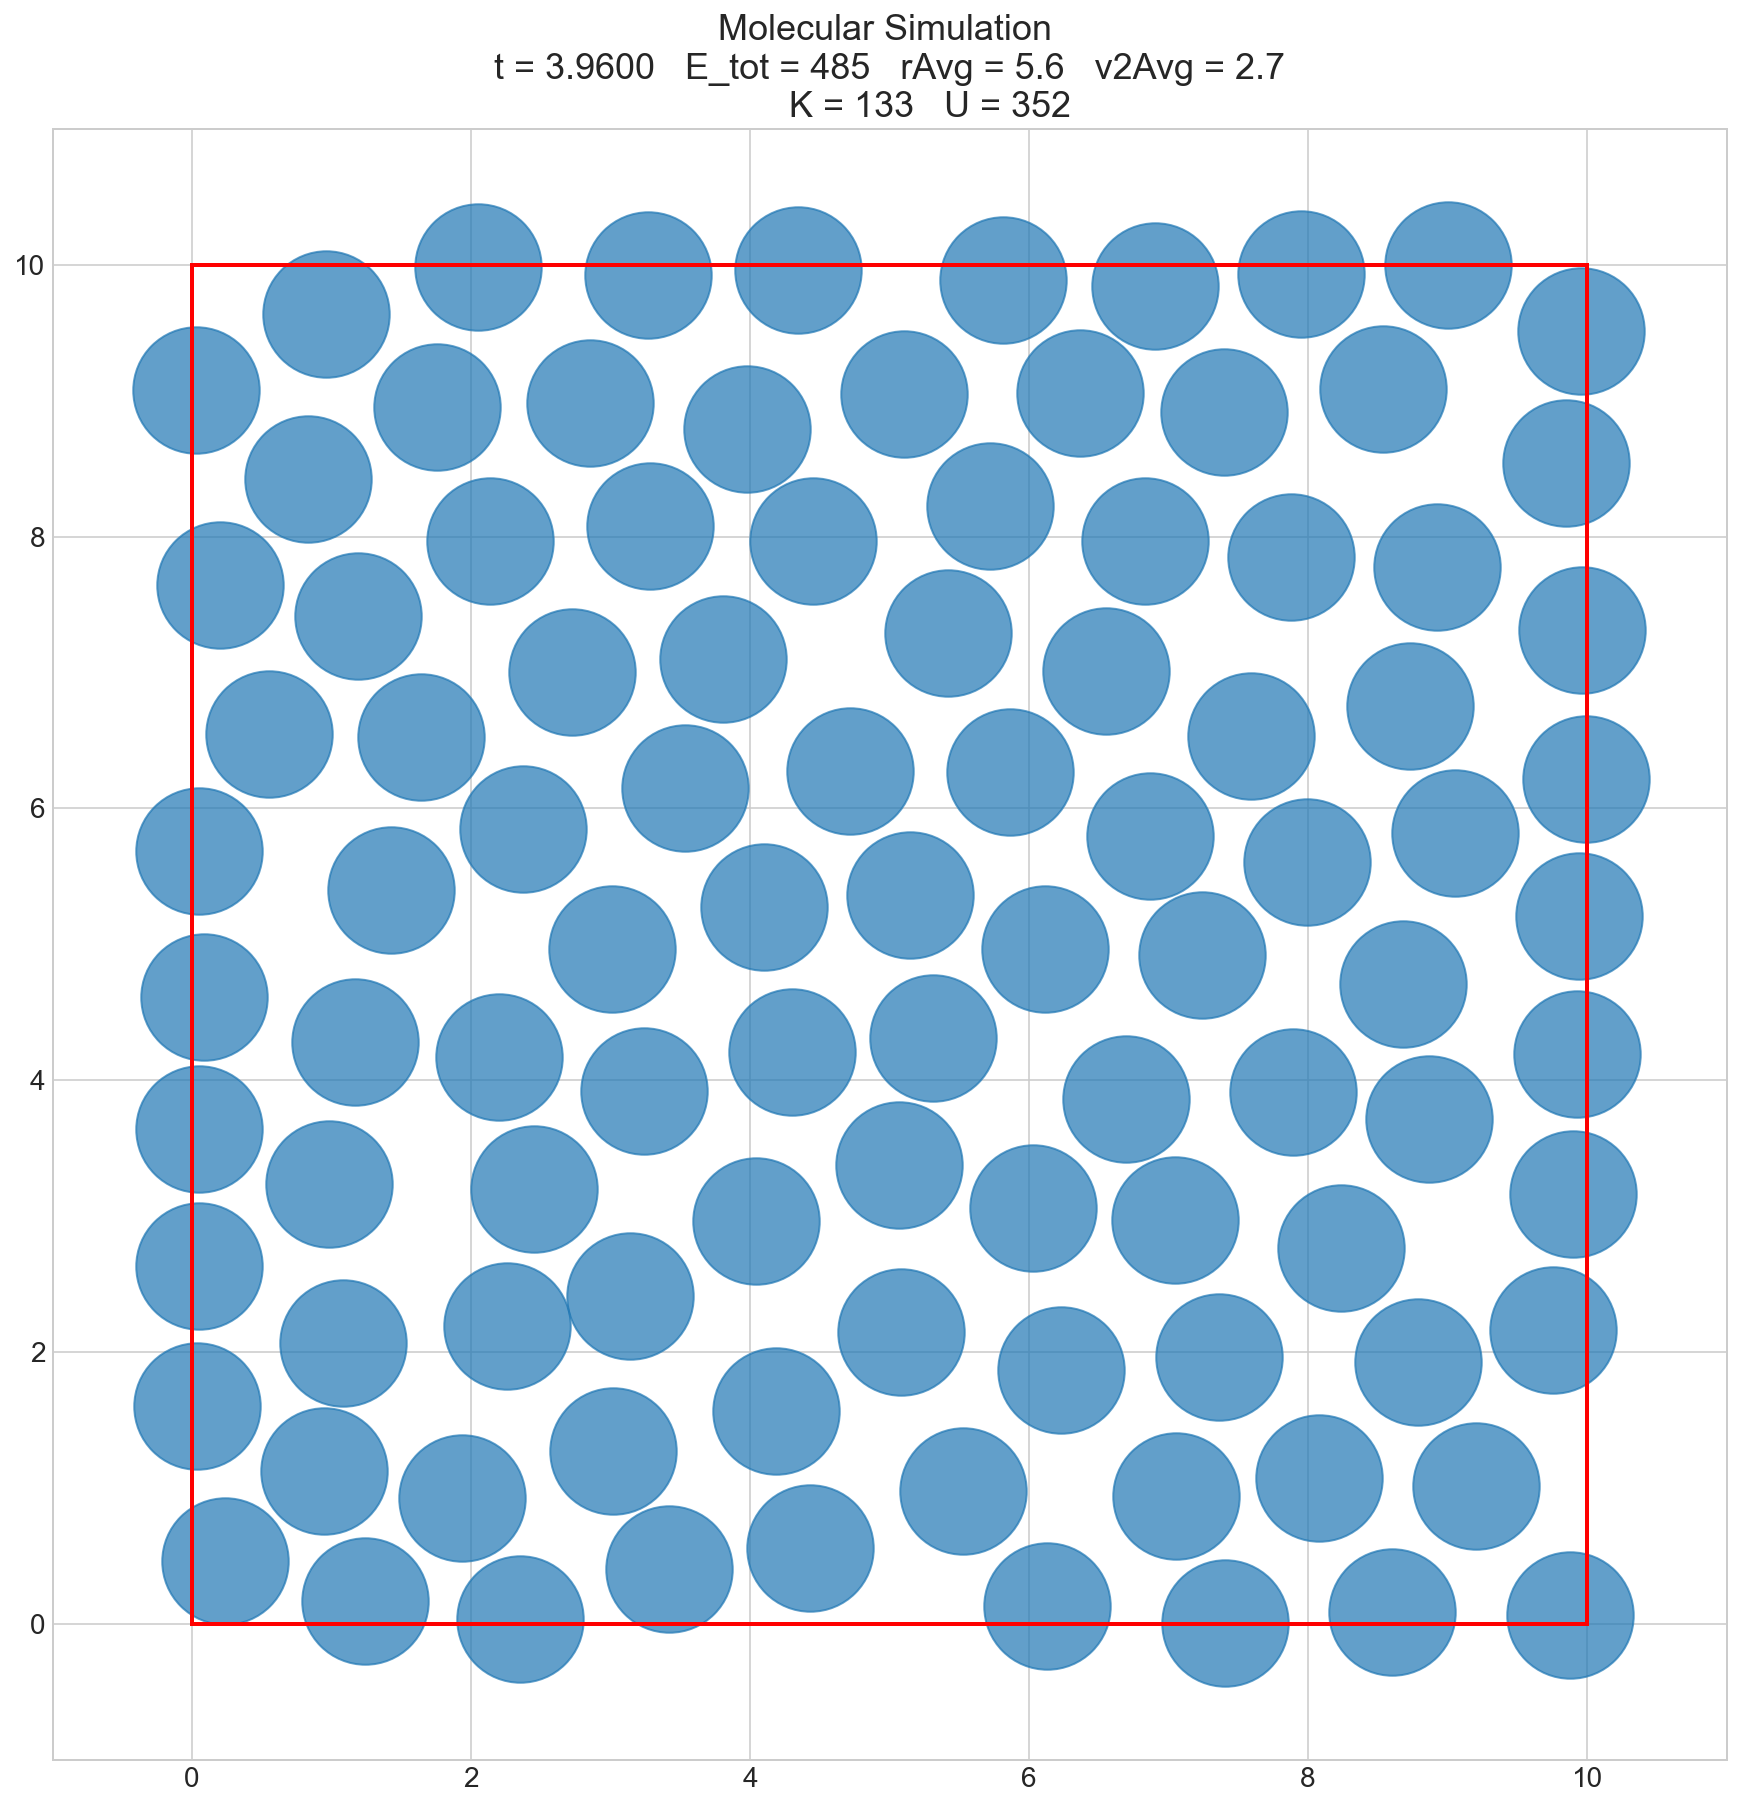

CPU times: user 1min 5s, sys: 1.19 s, total: 1min 6s
Wall time: 1min 6s


In [10]:
%%time
sim = Simulation(N=100, ε=1, L=10, η=0.1, r0=3, verbose=0, log_metrics=True)

for n in range(1,N_iter):
    sim.advance(Δt)
    if (n % display_freq) == 0:
        plot_iteration(sim, ax_size=15, p_size=4000, moving_avg=display_freq)
        
plt.close()

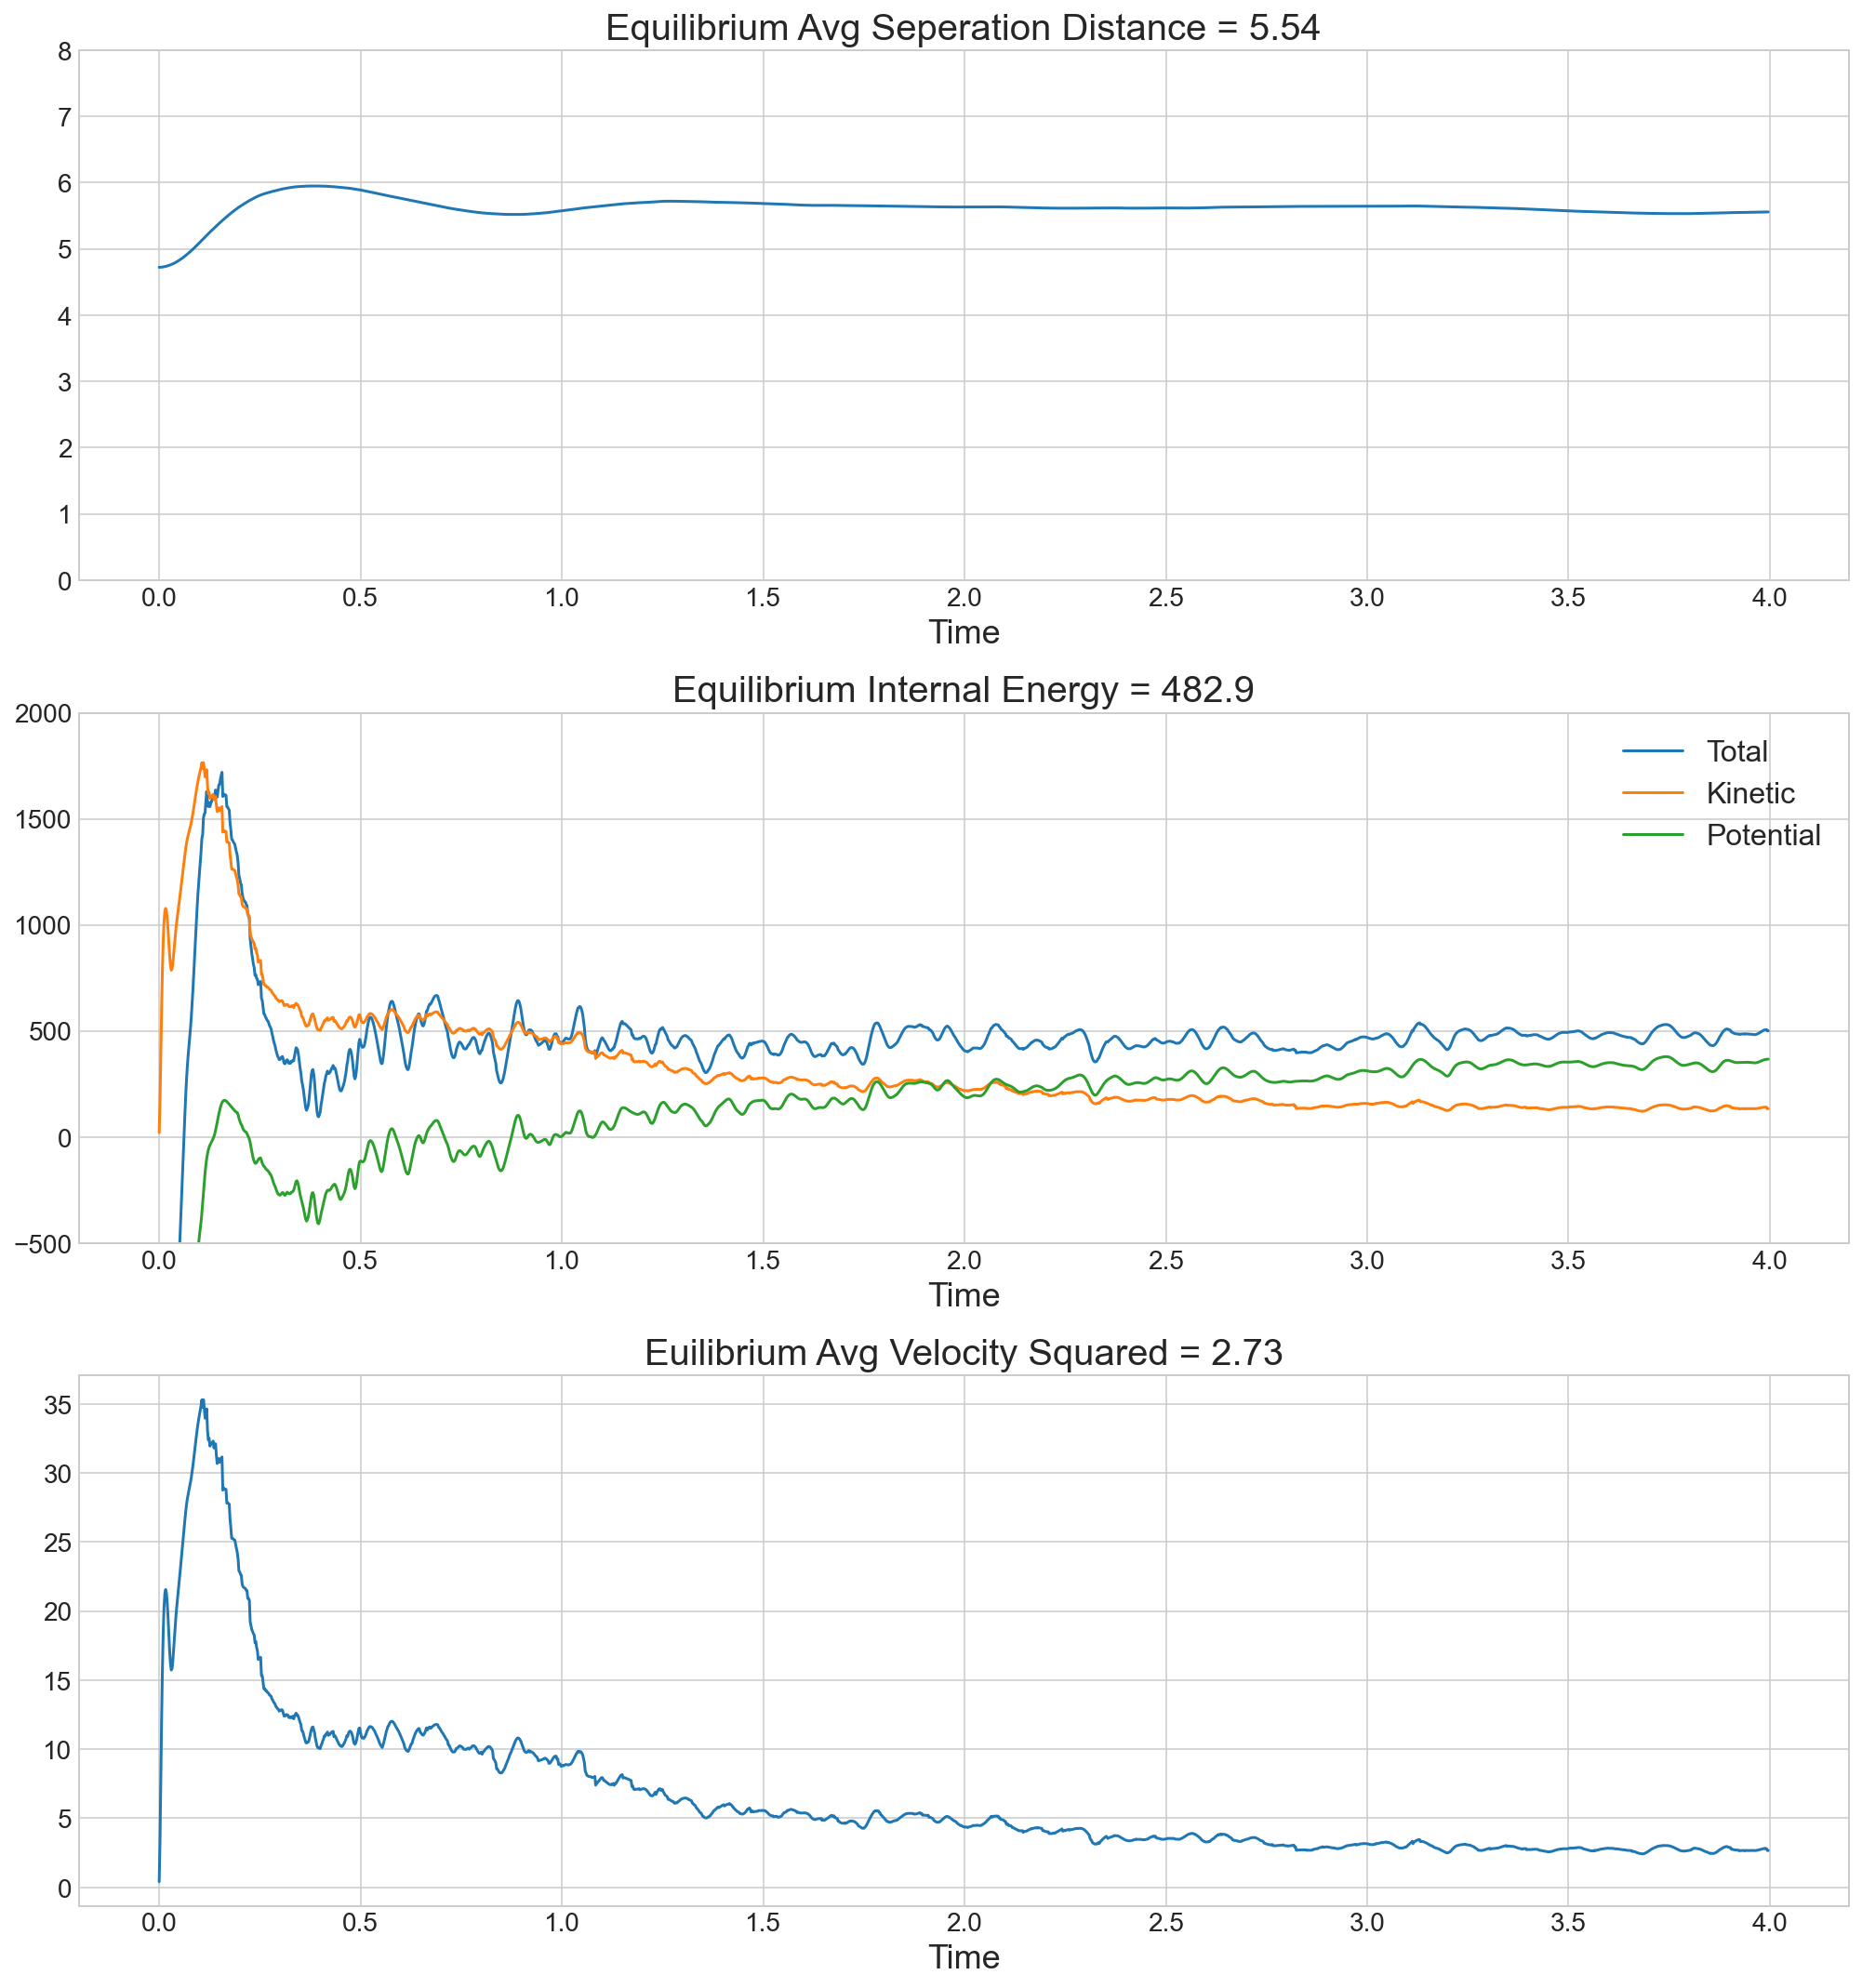

In [11]:
t = sim.t_steps

plt.figure(figsize=(14,15))

plt.subplot(3,1,1)
plt.plot(t, sim.rAvg)
plt.title("Equilibrium Avg Seperation Distance = {:.2f}".format(np.mean(sim.rAvg[int(len(t)*0.9):])), fontsize=20)
plt.xlabel("Time", fontsize=18)
plt.ylim([0,int(1.5*max(sim.rAvg))])

plt.subplot(3,1,2)
plt.plot(t, sim.E_tot, label="Total")
plt.plot(t, sim.K, label="Kinetic")
plt.plot(t, sim.U, label="Potential")
plt.title("Equilibrium Internal Energy = {:.1f}".format(np.mean(sim.E_tot[int(len(t)*0.9):])), fontsize=20)
plt.xlabel("Time", fontsize=18)
plt.ylim([-500, 2000])
plt.legend(prop={"size":16})

plt.subplot(3,1,3)
plt.plot(t, sim.v2Avg)
plt.title("Euilibrium Avg Velocity Squared = {:.2f}".format(np.mean(sim.v2Avg[int(len(t)*0.9):])), fontsize=20)
plt.xlabel("Time", fontsize=18)
plt.tight_layout()
plt.show()

## Cool Animation

In [12]:
frames = N_iter

sim = Simulation(N=100, ε=1, L=10, η=0.1, r0=3, verbose=0, log_metrics=False)

fig = plt.figure(figsize=(15, 15), dpi=100)
sim_ax = plt.gca()
sim_ax.set_xlim(-1, sim.L+1)
sim_ax.set_ylim(-1, sim.L+1)
sim_ax.set_title("Molecular Simulation", fontsize=30, y=1.01)
sim_ax.add_patch(patches.Rectangle(xy=(0, 0),  width=sim.L, height=sim.L, linewidth=2, color='red', fill=False))

particles, = sim_ax.plot([], [], 'bo', alpha=0.7)

label_1 = sim_ax.text(4, -1.6, 't = {:.1f}s'.format(0))
label_1.set_fontsize(22)


def init_anim():
    """Initialize the animation"""
    particles.set_data([], [])
    return particles, label_1 
    
def animate(i):
    """Advance the animation by one step and update the frame."""
    global sim, label_1 
    sim.advance(Δt)
    particles.set_data(sim.r[:, 0], sim.r[:, 1])
    particles.set_markersize(60)
    particles.set_alpha = 0.7
    
    label_1.set_text('t = {:.3f}s'.format(sim.t))
    label_1.set_fontsize(22)
    
    return particles, label_1 

anim = FuncAnimation(fig, animate, frames=frames, interval=10, init_func=init_anim)
anim.save('src/molecular_sim.mp4', fps=30)
plt.close()

In [ ]:
# Run this line to show animation in notebook. Wont work for more than ~500 frames
anim